# ČSK scraping
The aim of this notebook is to scrap data from [ČLK](https://www.dent.cz/zubni-lekari/abecedne) website to obtain current data about dentists in Czech republic 

In [2]:
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait, Select
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.action_chains import ActionChains
from selenium.webdriver.chrome.options import Options


from itertools import islice
from fake_useragent import UserAgent
from joblib import Parallel, delayed

import time
import pandas as pd
import numpy as np
import re
import json
import warnings
import json
import random
import string
import unidecode

warnings.filterwarnings('ignore')


In [3]:
PATH_CHROME = '/home/gary/Apps/chromedriver'
PATH_INTERMEDIATE = '../../data/intermediate/'
PATH_FINAL = '../../data/final/'

## Get members

### Get urls

In [9]:
def get_member_links():
    '''
     Return:
         l_info: scrapped info
    '''
    
    l_info = [] # general info about dentists
        
    try:
        driver = webdriver.Chrome(executable_path=PATH_CHROME)

        driver.get('https://www.dent.cz/zubni-lekari/abecedne')

        time.sleep(1)

        # Page counter
        counter = 0
        n_pages = 377
        while counter < n_pages: 
            main = WebDriverWait(driver, 15).until(
                EC.presence_of_element_located((By.CLASS_NAME, "main"))
            )
            doc_list = main.find_element(by=By.CLASS_NAME, value='cross-dentists-alphabetical')

            for i in doc_list.find_elements(by=By.CLASS_NAME,value='cross-dentists-alphabetical__item.col-12.col-md-6.col-lg-4.u-mb-md'):
                name = i.text
                link = i.find_element_by_css_selector('a').get_attribute('href')
                l_info.append([name, link])
                
            # Next page
            next_page_button = main.find_element(by=By.CLASS_NAME, value='box-pager__item.box-pager__btn.box-pager__btn--next')
            next_page_button.click()
            
            time.sleep(.5)
            counter += 1

        driver.close()
            
    except Exception as e:
        print(f'Error occured:', e)
        
    finally:
        return l_info
    


In [10]:
l_info = get_member_links()

In [11]:
dentists = pd.DataFrame(l_info, columns=['name', 'url'])
dentists = dentists[dentists.name != '']
dentists = dentists.drop_duplicates()
dentists

,name,url
0,Abdullah Anwer Lékař stomatolog,https://www.dent.cz/clen/78a69950-30d5-4948-84...
1,Abu Haija Moh'd,https://www.dent.cz/clen/04c897c9-9a89-426c-af...
2,Adamcová Libuše MUDr.,https://www.dent.cz/clen/fa37580d-5c03-4690-b1...
3,Abdulová Shirin MDDr.,https://www.dent.cz/clen/bf7597d9-8a65-4f57-86...
4,Ackermannová Michaela MDDr.,https://www.dent.cz/clen/55c14db6-4cc4-443a-81...
...,...,...
11296,Žůrková Michaela MDDr.,https://www.dent.cz/clen/4ce473e4-824f-4558-a7...
11298,Žmolíková Petra MUDr.,https://www.dent.cz/clen/4bbdf692-5cab-4c34-a2...
11301,Žmolová Klára MDDr.,https://www.dent.cz/clen/3405be9a-a390-4262-9a...
11304,Žmuráňová Lucia MDDr.,https://www.dent.cz/clen/d88f8d4b-b3de-4aab-8e...


In [13]:
dentists.to_csv(PATH_INTERMEDIATE + 'dentists_url.csv')

### Get detail

In [22]:
def get_detail(driver, url):
    d_detail = dict()
    
    try:
        driver.get(url)
        time.sleep(1)
        # load main content
        main = WebDriverWait(driver, 10).until(
            EC.presence_of_element_located((By.CLASS_NAME, "main"))
        )
            
        # name
        name = main.find_element(by=By.CLASS_NAME, value='d-flex.align-items-center').text
        d_detail['name'] = name

        
        text = main.find_element(by=By.CLASS_NAME, value='row-main').text
        areas = [x for x in text.split('\n') if "OSK" in x]
        d_detail['area'] = areas
        
        
        # workplaces
        workplaces_info = []
        workplaces = main.find_elements(by=By.CLASS_NAME, value='bg-lightgrey.p-3.mb-3')
        for workplace in workplaces:
            wp_info = workplace.find_elements(by=By.CLASS_NAME, value='col-md-8')
            for wp in wp_info:
                info = wp.text.split('\n')
                name, address = info[0], info[1]
                workplaces_info.append({'name': name, 'address':address})
        
        d_detail['workplace'] = workplaces_info
                
    finally:
        return d_detail 

In [79]:
# get_detail('https://www.dent.cz/clen/de737c67-3212-4905-b750-6b8de2d106a9')

In [17]:
l_detail = []

driver = webdriver.Chrome(executable_path=PATH_CHROME)
n_url = dentists.url.nunique()
cnt = 1

for url in dentists.url.unique():
    if cnt % 100 == 0:
        print('.', end='')
    if cnt % 1000 == 0:
        print(f' {cnt}/{n_url}')    
    cnt += 1    
    
    d_detail = get_detail(driver, url)
    d_detail['url'] = url
    l_detail.append(d_detail)
    
driver.close()


.......... 1000/11293
.......... 2000/11293
.......... 3000/11293
.......... 4000/11293
.......... 5000/11293
.......... 6000/11293
.......... 7000/11293
.......... 8000/11293
.......... 9000/11293
.......... 10000/11293
.......... 11000/11293
..

In [38]:
def save_to_json(rec, name):
    with open(PATH_INTERMEDIATE + name + '.json', "w") as outfile:
        json.dump(rec, outfile)

save_to_json(l_detail, 'dentists_all')

In [46]:
again = []
for item in l_detail:
    area = item.get('area', None)
    if not isinstance(area, list):
        print(item)
        again.append(item['url'])

{'url': 'https://www.dent.cz/clen/437b5e52-17f3-4398-a299-0adc58314635'}
{'url': 'https://www.dent.cz/clen/66e309a8-2c2f-41a9-8907-98c356c501de'}
{'url': 'https://www.dent.cz/clen/b5cf05be-4f88-4e15-abac-f34f0aa80bbc'}
{'url': 'https://www.dent.cz/clen/fe73d29a-f176-493c-a115-825a3e33fe32'}
{'url': 'https://www.dent.cz/clen/2a113271-ed82-4ed3-b1af-1dd7e8116596'}
{'url': 'https://www.dent.cz/clen/b10c5a58-95d9-4c52-b7a6-029902266b91'}
{'name': 'MUDr. Jáňová Radmila', 'url': 'https://www.dent.cz/clen/9f8377a1-25b8-432b-a962-6c5da41f0496'}
{'name': 'Zubní lékař', 'url': 'https://www.dent.cz/clen/21574579-9c6e-46e5-9b97-729eea8a6b7b'}
{'url': 'https://www.dent.cz/clen/84aa6918-a9b4-478c-af8d-c7b70a498878'}
{'url': 'https://www.dent.cz/clen/d57b7dbb-d8fc-422f-af5f-4d2024fb54fc'}
{'url': 'https://www.dent.cz/clen/a4f5d6c8-65c9-4a1b-8e0d-328504b612d7'}
{'url': 'https://www.dent.cz/clen/8e2e3419-fd5d-4cef-941e-c782c4727525'}
{'url': 'https://www.dent.cz/clen/73de6dd3-7894-411f-a5ae-4c386a405eb

In [44]:
driver = webdriver.Chrome(executable_path=PATH_CHROME)

for url in again:
    d_detail = get_detail(driver, url)
    d_detail['url'] = url
    l_detail.append(d_detail)
driver.close()

In [21]:
dentists[dentists.url.isin(again)]

[{'name': 'Lékař stomatolog Abdullah Anwer',
  'area': ['OSK PRAHA 9'],
  'workplace': [{'name': 'Zubní ordinace Úsměv s.r.o.',
    'address': 'Generála Janouška 902/17, 198 00, Praha 9'}],
  'url': 'https://www.dent.cz/clen/78a69950-30d5-4948-841a-be5a87712b8a'},
 {'name': "Abu Haija Moh'd",
  'area': ['OSK OSTRAVA'],
  'workplace': [],
  'url': 'https://www.dent.cz/clen/04c897c9-9a89-426c-af30-55f909c99399'},
 {'name': 'MUDr. Adamcová Libuše',
  'area': ['OSK PRAHA 5'],
  'workplace': [],
  'url': 'https://www.dent.cz/clen/fa37580d-5c03-4690-b108-0eab325b80c7'},
 {'name': 'MDDr. Abdulová Shirin',
  'area': ['OSK BRNO'],
  'workplace': [{'name': 'ALTADENT, spol. s.r.o.',
    'address': 'Merhautova 1070/224, 613 00, Brno'}],
  'url': 'https://www.dent.cz/clen/bf7597d9-8a65-4f57-86c8-366b97a2766f'},
 {'name': 'MDDr. Ackermannová Michaela',
  'area': ['OSK PLZEŇ'],
  'workplace': [{'name': 'SAFA Dent s.r.o.',
    'address': 'Masarykova 1132/62, 312 00, Plzeň'}],
  'url': 'https://www.den

## Get workplaces
### Get urls

In [49]:
def get_workplace_links():
    
    l_info = [] # general info about dentists
        
    try:
        driver = webdriver.Chrome(executable_path=PATH_CHROME)

        driver.get('https://www.dent.cz/zubni-lekari')
        time.sleep(1)

        # Page counter
        counter = 0
        n_pages = 232
        while counter < n_pages: 
            main = WebDriverWait(driver, 15).until(
                EC.presence_of_element_located((By.CLASS_NAME, "main"))
            )
            wp_list = main.find_element(by=By.CLASS_NAME, value='cross-cross-dentists-list')

            for i in wp_list.find_elements(by=By.CLASS_NAME,value='cross-dentists-list__item.col-12.col-md-6.u-mb-md'):
                record = i.find_element_by_css_selector('a')
                name = record.text
                link = record.get_attribute('href')
                l_info.append([name, link])
                
            # Next page
            next_page_button = main.find_element(by=By.CLASS_NAME, value='box-pager__item.box-pager__btn.box-pager__btn--next')
            next_page_button.click()
            
            time.sleep(.5)
            counter += 1

        driver.close()
            
    except Exception as e:
        print(f'Error occured:', e)
        
    finally:
        return l_info

In [51]:
l_workplaces = get_workplace_links()

In [52]:
workplaces = pd.DataFrame(l_workplaces, columns=['name', 'url'])
# workplaces = workplaces[workplaces.name != '']
# dentists = dentists.drop_duplicates()
workplaces

,name,url
0,#staycool s.r.o.,https://www.dent.cz/zubar/df313eba-7447-4496-b...
1,0-100 DENT s.r.o.,https://www.dent.cz/zubar/41b6caf3-48b0-4e43-a...
2,0-100 DENT s.r.o.,https://www.dent.cz/zubar/c30146a2-8fc8-4a59-a...
3,1. LF Dental s.r.o.,https://www.dent.cz/zubar/48d9dea2-88ad-41b8-b...
4,1. LF Dental s.r.o.,https://www.dent.cz/zubar/55722298-9ec7-4b6a-8...
...,...,...
6937,Zubzit497 s.r.o.,https://www.dent.cz/zubar/8eec538b-98cf-428f-b...
6938,"ZUOP, s.r.o.",https://www.dent.cz/zubar/4158473a-ae6a-4199-9...
6939,ZvolanekDental s.r.o.,https://www.dent.cz/zubar/13723870-c043-4ace-a...
6940,ZvolanekDental s.r.o.,https://www.dent.cz/zubar/93fc7228-bc39-4c73-8...


In [53]:
workplaces.to_csv(PATH_INTERMEDIATE + 'dentists_workplaces.csv')

### Get detail

In [132]:
def get_wp_detail(driver, url):
    d_detail = dict()
    
    try:
        driver.get(url)
        time.sleep(2)
        # load main content
        main = WebDriverWait(driver, 15).until(
            EC.presence_of_element_located((By.CLASS_NAME, "main"))
        )
            
        # name
        name = main.find_element_by_css_selector('h1').text
        d_detail['name'] = name
        
        # detail info
        workplaces_info = []
        table = main.find_element(by=By.CLASS_NAME, value='box-detail__item')
        info = table.find_elements_by_css_selector('p')
        
        if len(info) % 2 != 0:
            print(f'Alert [{url}]: probably bad parsing')
        
        for feature, value in zip(info[::2], info[1::2]):
            key = feature.text
            val = value.text.split('\n')
            d_detail[key] = val
                
    finally:
        return d_detail 

In [63]:
# driver = webdriver.Chrome(executable_path=PATH_CHROME)
# get_wp_detail(driver, 'https://www.dent.cz/zubar/816e0470-99c2-445d-8dcf-788d213fc135')


In [67]:
l_wp_detail = []

driver = webdriver.Chrome(executable_path=PATH_CHROME)
n_url = workplaces.url.nunique()
cnt = 1

for url in workplaces.url.unique():
    if cnt % 100 == 0:
        print('.', end='')
    if cnt % 1000 == 0:
        print(f' {cnt}/{n_url}')    
    cnt += 1    
    
    d_detail = get_wp_detail(driver, url)
    d_detail['url'] = url
    l_wp_detail.append(d_detail)
    
driver.close()


Alert [https://www.dent.cz/zubar/0c142114-d1a1-46bf-bec6-0ef5ca78223b]: probably bad parsing
Alert [https://www.dent.cz/zubar/4f0e1f91-f7eb-443a-8701-49174d14bc7d]: probably bad parsing
Alert [https://www.dent.cz/zubar/d54cc2b1-6d4b-4942-b17b-b0efd35b2de4]: probably bad parsing
Alert [https://www.dent.cz/zubar/4d805d62-1bc9-44bf-882f-ab13c8b3cd97]: probably bad parsing
Alert [https://www.dent.cz/zubar/ad24ce7d-1fe2-4db2-8e09-3859e8b56a36]: probably bad parsing
Alert [https://www.dent.cz/zubar/1e655648-4d8e-4419-80ee-51a697df3256]: probably bad parsing
Alert [https://www.dent.cz/zubar/b27602cb-ea97-40a4-829f-911dd2039662]: probably bad parsing
Alert [https://www.dent.cz/zubar/8fa2d49e-dde7-4e8a-a14c-f412d6580013]: probably bad parsing
Alert [https://www.dent.cz/zubar/161ede3f-28b5-4f0d-b83c-aa6f11232f39]: probably bad parsing
Alert [https://www.dent.cz/zubar/a49839c5-e00e-4285-af59-fc82bd03ad34]: probably bad parsing
Alert [https://www.dent.cz/zubar/050e4adf-e9dc-49cd-aa89-78842b91399c]

In [151]:
save_to_json(l_wp_detail, 'workplaces_all')

In [69]:
workplaces = pd.DataFrame(l_wp_detail)
workplaces.columns =['workplace_name', 'workplace_address', 'dentist', 'workplace_url', 'insurance_companies']
workplaces = workplaces.explode('dentist').reset_index(drop=True)
workplaces

,name,Kontakty:,Zubní lékaři:,url,Pojišťovny:
0,#staycool s.r.o.,"[J.E.Purkyně 365, 686 06 Uherské Hradiště]",[MDDr. Stašková Alžběta],https://www.dent.cz/zubar/df313eba-7447-4496-b...,NaN
1,0-100 DENT s.r.o.,"[Thákurova 534/10, 160 00 Praha 6]",[MUDr. Hůlková Petra],https://www.dent.cz/zubar/41b6caf3-48b0-4e43-a...,NaN
2,0-100 DENT s.r.o.,"[Újezd 427/28, 118 00 Praha 1]",[],https://www.dent.cz/zubar/c30146a2-8fc8-4a59-a...,NaN
3,1. LF Dental s.r.o.,"[ZS Jaderná elektrárna Temelín, 373 05 Temelín...",[MDDr. Fechtnerová Lenka],https://www.dent.cz/zubar/48d9dea2-88ad-41b8-b...,NaN
4,1. LF Dental s.r.o.,"[Senovážná 864/1, 110 00 Praha 1]",[MDDr. Fechtnerová Lenka],https://www.dent.cz/zubar/55722298-9ec7-4b6a-8...,NaN
...,...,...,...,...,...
6903,Zubzit497 s.r.o.,"[Žitavského 497, 156 00 Praha 5]","[MDDr. Kohoutová Tereza, MDDr. Sekavová Tereza...",https://www.dent.cz/zubar/8eec538b-98cf-428f-b...,NaN
6904,"ZUOP, s.r.o.","[Holubická 7, 664 07 Pozořice, E-mail: info@z...","[MUDr. Schrumpfová Olga, MUDr. Nekudová Schrum...",https://www.dent.cz/zubar/4158473a-ae6a-4199-9...,"[RBP, VoZP, OZP, ČPZP, ZPMV, VZP]"
6905,ZvolanekDental s.r.o.,"[Alej Svobody 732/55, 323 00 Plzeň, E-mail: i...","[MDDr. Kabátová Veronika, MDDr. Petříková Tere...",https://www.dent.cz/zubar/13723870-c043-4ace-a...,NaN
6906,ZvolanekDental s.r.o.,"[nám. Generála Píky 2703/27, 326 00 Plzeň]",[],https://www.dent.cz/zubar/93fc7228-bc39-4c73-8...,NaN


## Postprocessing

### Dentists

In [153]:
with open(PATH_INTERMEDIATE + 'dentists_all.json', "r") as f:
    dentists = json.load(f)

In [154]:
# urls = dentists_df[(dentists_df.name.isna()) |(dentists_df.name =='Zubní lékař')].url.unique()

# driver = webdriver.Chrome(executable_path=PATH_CHROME)
# # l_detail = []
# for url in urls:
#     d_detail = get_detail(driver, url)
#     d_detail['url'] = url
#     l_detail.append(d_detail)
# driver.close()

In [155]:
dentists_df = pd.json_normalize(dentists)
dentists_df = dentists_df.drop_duplicates('url', keep='last')
dentists_df = dentists_df[~((dentists_df.name.isna()) |(dentists_df.name =='Zubní lékař'))]
dentists_df = dentists_df.reset_index(drop=True)

# get their OSK
area_na = dentists_df['area'].isna()
dentists_df.loc[~area_na, 'area'] = dentists_df[~area_na]['area'].apply(lambda x: x[0] if x else np.nan)

In [156]:
# Age
# estimate an age based on students age at the time they graduated and their probabilities
students = pd.read_csv(PATH_FINAL+'students.csv', index_col=0)

dr = students[(students['graduated'] == True) & (students.major == 'Zubní lékařství')][['graduated', 'major', 'age_end']]

ages = dr.age_end.value_counts().reset_index()
ages.columns = ['age','count']
n_records = sum(ages['count'])
ages['p'] = ages['count'] / n_records
display(ages.head())


random_age = np.random.choice(ages['age'], p=ages['p'], size=dentists_df.shape[0])
dentists_df['graduated_age_estimate'] = random_age
dentists_df['graduated_age_estimate'] = dentists_df['graduated_age_estimate'].apply(round)

# TODO based on CLK dataset + students info estimate graduate year


# dentists_df['age_estimated'] = dentists_df['graduated_age_estimated'] + (dentists_df.today().year - dentists_df['graduated_year']) 

dentists_df

,age,count,p
0,24.0,1165,0.352390
1,25.0,687,0.207804
2,26.0,310,0.093769
3,28.0,267,0.080762
4,29.0,180,0.054446


,name,area,workplace,url,graduated_age_estimate
0,Lékař stomatolog Abdullah Anwer,OSK PRAHA 9,"[{'name': 'Zubní ordinace Úsměv s.r.o.', 'addr...",https://www.dent.cz/clen/78a69950-30d5-4948-84...,25
1,Abu Haija Moh'd,OSK OSTRAVA,[],https://www.dent.cz/clen/04c897c9-9a89-426c-af...,24
2,MUDr. Adamcová Libuše,OSK PRAHA 5,[],https://www.dent.cz/clen/fa37580d-5c03-4690-b1...,24
3,MDDr. Abdulová Shirin,OSK BRNO,"[{'name': 'ALTADENT, spol. s.r.o.', 'address':...",https://www.dent.cz/clen/bf7597d9-8a65-4f57-86...,25
4,MDDr. Ackermannová Michaela,OSK PLZEŇ,"[{'name': 'SAFA Dent s.r.o.', 'address': 'Masa...",https://www.dent.cz/clen/55c14db6-4cc4-443a-81...,25
...,...,...,...,...,...
11272,MUDr. Wiesnerová Beatrice,OSK OPAVA,[],https://www.dent.cz/clen/c2d170e1-5ded-4ade-a7...,27
11273,MDDr. Weinerová Pavla,OSK BRNO,[{'name': 'DENTINA PRIVÁTNÍ ZUBNÍ ORDINACE s.r...,https://www.dent.cz/clen/82945e57-5184-4cb9-98...,28
11274,MUDr. Weitzová Drahomíra,OSK MOST,[],https://www.dent.cz/clen/0bdcc212-2a97-4112-bc...,25
11275,MUDr. Wicherová Jindra,OSK PRAHA 4,"[{'name': 'MUDr. Wicherová Jindra', 'address':...",https://www.dent.cz/clen/9e380d61-bc2c-4b7c-94...,31


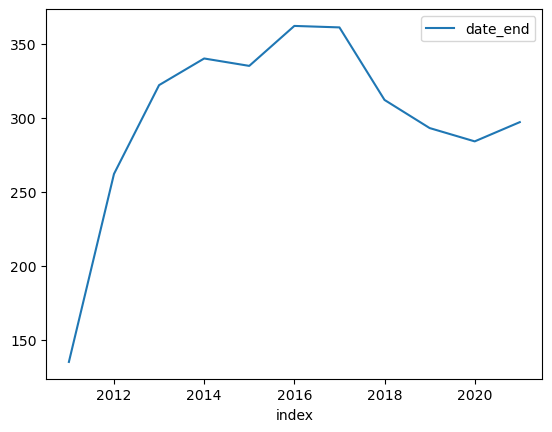

In [157]:
x=students[(students['graduated']==True) & (students['major'] == 'Zubní lékařství') & (students['date_end'] < 2022)].date_end.value_counts().sort_index().reset_index()
x.plot(y='date_end', x='index')

In [158]:
# explode workplace
dentists_df['workplace'] = dentists_df['workplace'].apply(lambda x: x if x else np.nan)
dentists_df = dentists_df.explode('workplace')

In [159]:
n_workplaces_df = pd.DataFrame(dentists_df.url.value_counts()).reset_index()
n_workplaces_df.columns = ['url', 'n_doctor_workplaces']
dentists_df = pd.merge(dentists_df, n_workplaces_df, on='url')
dentists_df.loc[dentists_df.workplace.isna(), 'n_doctor_workplaces'] = 0

In [161]:
dentists_wp_df = dentists_df['workplace'].apply(pd.Series).drop([0], axis=1)
dentists_wp_df.columns = ['workplace_address', 'workplace_name']
dentists_parsed = pd.concat([dentists_df.drop(['workplace'], axis=1), dentists_wp_df], axis=1)

dentists_parsed['medical_specialty'] = '[stomatologie]'
dentists_parsed['private_practice']  = '[stomatologie]'

dentists_parsed = dentists_parsed.rename(columns={'url':'doctor_url'})

In [162]:
## parse address

def get_zip_code(address):
    idx = re.search(r"\d\d\d \d\d", address)
    if idx:
        idx = idx.start()
        zip_code = re.sub(' ', '',address[idx:idx+6])
        return int(zip_code)
    else:
        idx = re.search(r"\d\d\d\d\d", address)
        if not idx:
            return np.nan
        idx = idx.start()
        return int(address[idx:idx+5])

def get_street(address):
    idx = re.search(r", \d\d\d", address)
    l = address.split(',')
    
    if not idx or len(l) <= 2:
        return np.nan
    
    idx = idx.start()
    return address[:idx]

def get_city(address):
    idx = re.search(r"\d\d\d \d\d,", address)
    if not idx:
        idx = re.search(r"\d\d\d\d\d,", address)
        if not idx:
            return np.nan
    idx = idx.end()
    return address[idx:]
        

wp_na = dentists_parsed['workplace_address'].isna()

dentists_parsed['zip_code'] = dentists_parsed[~wp_na].workplace_address.apply(get_zip_code)
dentists_parsed['street'] = dentists_parsed[~wp_na].workplace_address.apply(get_street)
dentists_parsed['city'] = dentists_parsed[~wp_na].workplace_address.apply(get_city)

In [163]:
dentists_parsed = dentists_parsed.rename({'name' : 'doctor_name'}, axis=1)
dentists_parsed['_id'] = dentists_parsed.doctor_url.apply(lambda x: x[len('https://www.dent.cz/clen/'):])
dentists_parsed

,doctor_name,area,doctor_url,graduated_age_estimate,n_doctor_workplaces,workplace_address,workplace_name,medical_specialty,private_practice,zip_code,street,city,_id
0,Lékař stomatolog Abdullah Anwer,OSK PRAHA 9,https://www.dent.cz/clen/78a69950-30d5-4948-84...,25,1,"Generála Janouška 902/17, 198 00, Praha 9",Zubní ordinace Úsměv s.r.o.,[stomatologie],[stomatologie],19800.0,Generála Janouška 902/17,Praha 9,78a69950-30d5-4948-841a-be5a87712b8a
1,Abu Haija Moh'd,OSK OSTRAVA,https://www.dent.cz/clen/04c897c9-9a89-426c-af...,24,0,NaN,NaN,[stomatologie],[stomatologie],NaN,NaN,NaN,04c897c9-9a89-426c-af30-55f909c99399
2,MUDr. Adamcová Libuše,OSK PRAHA 5,https://www.dent.cz/clen/fa37580d-5c03-4690-b1...,24,0,NaN,NaN,[stomatologie],[stomatologie],NaN,NaN,NaN,fa37580d-5c03-4690-b108-0eab325b80c7
3,MDDr. Abdulová Shirin,OSK BRNO,https://www.dent.cz/clen/bf7597d9-8a65-4f57-86...,25,1,"Merhautova 1070/224, 613 00, Brno","ALTADENT, spol. s.r.o.",[stomatologie],[stomatologie],61300.0,Merhautova 1070/224,Brno,bf7597d9-8a65-4f57-86c8-366b97a2766f
4,MDDr. Ackermannová Michaela,OSK PLZEŇ,https://www.dent.cz/clen/55c14db6-4cc4-443a-81...,25,1,"Masarykova 1132/62, 312 00, Plzeň",SAFA Dent s.r.o.,[stomatologie],[stomatologie],31200.0,Masarykova 1132/62,Plzeň,55c14db6-4cc4-443a-8184-b6f35b67e384
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12819,MUDr. Wiesnerová Beatrice,OSK OPAVA,https://www.dent.cz/clen/c2d170e1-5ded-4ade-a7...,27,0,NaN,NaN,[stomatologie],[stomatologie],NaN,NaN,NaN,c2d170e1-5ded-4ade-a792-16ee06d35182
12820,MDDr. Weinerová Pavla,OSK BRNO,https://www.dent.cz/clen/82945e57-5184-4cb9-98...,28,1,"Košinova 3105/18a, 612 00, Brno",DENTINA PRIVÁTNÍ ZUBNÍ ORDINACE s.r.o.,[stomatologie],[stomatologie],61200.0,Košinova 3105/18a,Brno,82945e57-5184-4cb9-9884-8b8d98901082
12821,MUDr. Weitzová Drahomíra,OSK MOST,https://www.dent.cz/clen/0bdcc212-2a97-4112-bc...,25,0,NaN,NaN,[stomatologie],[stomatologie],NaN,NaN,NaN,0bdcc212-2a97-4112-bca0-777439d22dfd
12822,MUDr. Wicherová Jindra,OSK PRAHA 4,https://www.dent.cz/clen/9e380d61-bc2c-4b7c-94...,31,1,"Soukalova 3355, 143 00, Praha 4",MUDr. Wicherová Jindra,[stomatologie],[stomatologie],14300.0,Soukalova 3355,Praha 4,9e380d61-bc2c-4b7c-9434-5405480500ac


### Workplaces

In [164]:
with open(PATH_INTERMEDIATE + 'workplaces_all.json', "r") as f:
    workplaces = json.load(f)

In [165]:
workplaces_df = pd.json_normalize(workplaces)
workplaces_df = workplaces_df.drop_duplicates('url', keep='last').reset_index(drop=True)
workplaces_df.columns = ['workplace_name', 'workplace_address', 'doctor_name', 'workplace_url', 'IC']

In [166]:
workplaces_df = workplaces_df[workplaces_df.workplace_name != ''].reset_index(drop=True)
workplaces_df.loc[len(workplaces_df)] = ['Family Dent s.r.o.', ['Chválenická 37, 326 00 Plzeň'], ['MUDr. Rousová Marcela'], 'https://www.dent.cz/zubar/259a2138-8b26-4fce-84b4-df8778cc8c1a', np.nan]

In [167]:
# number of companies' workplaces
n_workplaces = workplaces_df.workplace_name.value_counts().reset_index()
n_workplaces.columns = ['workplace_name', 'n_workplaces']
workplaces_df = pd.merge(workplaces_df, n_workplaces)

In [168]:
# urls  = workplaces_df[(workplaces_df.name.isna()) |(workplaces_df.name =='Načítám zubního lékaře...')].url.unique()

# l_wp_detail = []
# driver = webdriver.Chrome(executable_path=PATH_CHROME)
# for url in urls:   
#     d_detail = get_wp_detail(driver, url)
#     d_detail['url'] = url
#     l_wp_detail.append(d_detail)
    
# driver.close()

In [169]:
address_na = workplaces_df.workplace_address.isna()
workplaces_df.loc[~address_na,'workplace_address'] = workplaces_df[~address_na]['workplace_address'].apply(lambda address: [x for x in address if not 'E-mail' in x])
workplaces_df.loc[~address_na, 'workplace_address'] = workplaces_df[~address_na].workplace_address.apply(lambda x: ', '.join(x))

In [170]:
dentist_na = workplaces_df.doctor_name.isna()
workplaces_df.loc[~dentist_na, 'n_doctors_in_workplace'] = workplaces_df[~dentist_na].doctor_name.apply(len)
workplaces_df.loc[dentist_na, 'n_doctors_in_workplace'] = 0

In [171]:
workplaces_df = workplaces_df.explode('doctor_name').reset_index(drop=True)
dentist_na = workplaces_df.doctor_name == ''
workplaces_df.loc[dentist_na, 'doctor_name'] = np.nan
workplaces_df.loc[dentist_na, 'n_doctors_in_workplace'] = 0


In [172]:
## parse address
def get_street(address):
    idx = re.search(r", \d\d\d", address)
    l = address.split(',')
    
    if not idx or len(l) <= 1:
        return np.nan
    
    idx = idx.start()
    return address[:idx]

def get_city(address):
    idx = re.search(r"\d\d\d \d\d", address)
    if not idx:
        idx = re.search(r"\d\d\d\d\d", address)
        if not idx:
            return np.nan
    idx = idx.end()
    return address[idx:]
        


address_na = workplaces_df.workplace_address.isna()
workplaces_df['zip_code'] = workplaces_df[~address_na].workplace_address.apply(get_zip_code)
workplaces_df['street'] = workplaces_df[~address_na].workplace_address.apply(get_street)
workplaces_df['city'] = workplaces_df[~address_na].workplace_address.apply(get_city)

### Merge

In [173]:
dent_merge = pd.merge(workplaces_df, dentists_parsed,
                        on=['doctor_name', 'workplace_name', 'zip_code','street', 'city'],
                        how='right')

print(f'Merged workspaces: {dent_merge.workplace_url.nunique()}\nTotal workspaces: {workplaces_df[~workplaces_df.doctor_name.isna()].workplace_url.nunique()}')
print(f'Merged doctors: {dent_merge.doctor_url.nunique()}\nTotal doctors: {dentists_parsed.doctor_url.nunique()}')
print(f'Doctors with workplace: {dentists_parsed[~dentists_parsed.workplace_address.isna()].doctor_url.nunique()}')

dent_merge = (dent_merge.drop(columns=['workplace_address_x'])
                        .rename({'workplace_address_y' : 'workplace_address'}, axis=1))

# dent_merge.to_csv(PATH_INTERMEDIATE+'dentists_merged.csv')

Merged workspaces: 6159
Total workspaces: 6186
Merged doctors: 11277
Total doctors: 11277
Doctors with workplace: 8512


In [174]:
dent_merge.to_csv(PATH_FINAL+'dentists.csv')

### Estimation of the age of dentists

In [294]:
grad_ages = dent_merge.drop_duplicates('_id')['graduated_age_estimate'].value_counts().reset_index(name='count')
grad_ages.columns = ['grad_age_estimate', 'count']

n_dentists = dent_merge.drop_duplicates('_id').shape[0]
ds_ratio = 0.7724 # see section 3.1 in visualization.ipynb

students = pd.read_csv(PATH_FINAL+'students.csv', index_col=0)
students = students[(students.major == 'Zubní lékařství')
                    & (students.graduated == True)
                    & (students.date_end < 2022)
                    & (students.date_end > 2011)]
grad_counts = students.date_end.value_counts().reset_index(name='count')
grad_counts.columns = ['year', 'count']

std = np.std(grad_counts['count'])
mean = grad_counts['count'].mean()

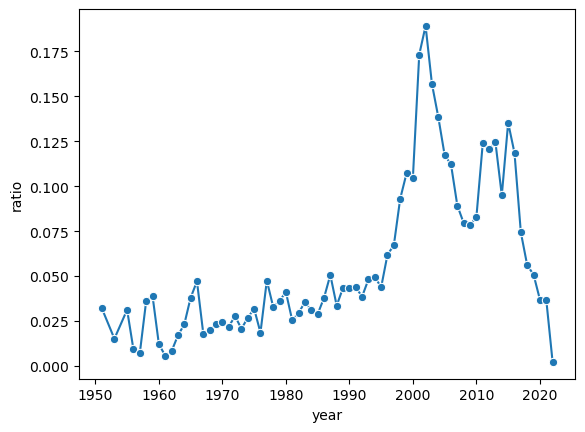

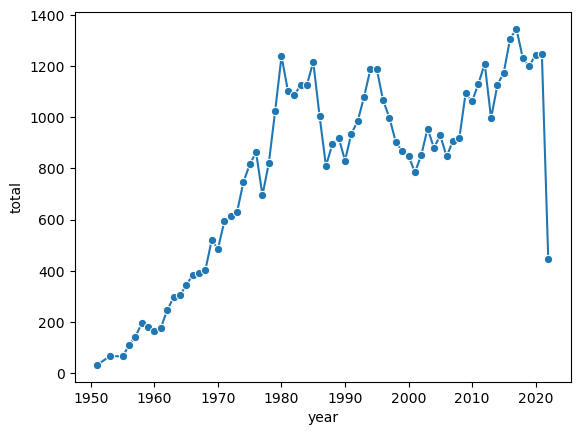

In [319]:
doctors = pd.read_csv(PATH_FINAL+'doctors.csv', index_col=0).drop_duplicates('_id')
graduate_docs = doctors[['graduated_year', 'university']].groupby('graduated_year').count()
graduate_docs_abroad = doctors[doctors.university == 'ABROAD'][['graduated_year', '_id']].groupby('graduated_year').count()
abroads = pd.merge(graduate_docs_abroad,graduate_docs, left_index=True, right_index=True).reset_index()
abroads.columns = ['year', 'abroad', 'total']
abroads['ratio'] = abroads['abroad'] / abroads['total']

d_abroads = pd.Series(abroads['ratio'].values,index=abroads['year']).to_dict()

import matplotlib.pyplot as plt
import seaborn as sns
sns.lineplot(y=abroads.ratio, x=abroads.year, marker="o", linewidth = 1.5)
plt.show()
sns.lineplot(y=abroads.total, x=abroads.year, marker="o", linewidth = 1.5)

In [317]:
# years 2012-2021

d_new_dentists = dict() # year : number of new dentists in CSK
sum = 0

for year in grad_counts.year.unique():
    new_dentists = round((1+d_abroads[year])*ds_ratio*grad_counts.loc[grad_counts.year ==year, 'count'].values[0])
    d_new_dentists[year] = new_dentists
    sum += new_dentists

print(f'New dentists between {int(grad_counts.year.min())}-{int(grad_counts.year.max())}: {sum}')


# for years < 2012
year = grad_counts.year.min()-1
while sum < n_dentists:
    graduates = np.random.normal(loc=mean, scale=std)

    local_dentsist = ds_ratio*graduates
    new_dentists = round(local_dentsist * (1+d_abroads[year]))
    d_new_dentists[year] = new_dentists

    sum += new_dentists
    year -= 1

print(year, sum)


New dentists between 2012-2021: 2659.0
1977.0 11398.0


In [344]:
years = np.array([]) # year of becoming a CSK member
for year, nums in d_new_dentists.items():
    if len(years) + nums <= n_dentists:
        years = np.append(years,np.full(int(nums), year))
    else:
        print(f'Last year: {year}')
        years = np.append(years,np.full(int(n_dentists-len(years)), year))

assert n_dentists == len(years)

Last year: 1978.0


In [354]:
dentists_ages = pd.DataFrame()
dentists_ages['age_end_estimate'] = dent_merge.drop_duplicates('_id').graduated_age_estimate.to_list()
dentists_ages['date_end_estimate'] = years
dentists_ages['age_now_estimate'] = (2022-dentists_ages['date_end_estimate'])+dentists_ages['age_end_estimate']

dentists_ages.to_csv(PATH_FINAL+'dentists_age_estimate.csv')
dentists_ages

,age_end_estimate,date_end_estimate,age_now_estimate
0,25,2016.0,31.0
1,24,2016.0,30.0
2,24,2016.0,30.0
3,26,2016.0,32.0
4,24,2016.0,30.0
...,...,...,...
11272,24,1978.0,68.0
11273,25,1978.0,69.0
11274,24,1978.0,68.0
11275,27,1978.0,71.0
